<img style="float: left;" src="resources/made.jpg" width="35%" height="35%" />

# Академия MADE

# Семинар 8

Преподаватель: Иван Карпухин, ведущий программист-исследователь команды машинного зрения.

<div style="clear:both;"></div>

Для выполнения работы нужны следующие пакеты (Python 3):
* filterpy
* matplotlib
* numpy
* opencv-python
* tqdm
* pyyaml

Установить их можно командой:
```bash
pip install -q filterpy matplotlib numpy opencv-python tqdm pyyaml
```

In [1]:
# Раскомментируйте строчку ниже, чтобы установить зависимости:
!pip install -q filterpy matplotlib numpy opencv-python tqdm pyyaml

## Часть 1. Трекинг: фильтр Калмана

В этой части семинара применим фильтр Калмана к предсказанию перемещения людей.

Мы воспользуемся готовой реализацией фильтра. В рамках семинара предлагается настроить парметры фильтра и применить его.

In [2]:
from IPython.display import Video

import numpy as np
from matplotlib import pyplot as plt

import check
import seminar

In [3]:
# Исходное видео:
VIDEO_PATH = "data/sample.mp4"

# Видео с обнаруженными лицами:
DEMO_PATH = "data/sample-demo.mp4"

# Результаты работы детектора:
DETECTIONS_PATH = "data/sample-tracks.yaml"

# Видео, куда сохранится результат трекинга:
OUTPUT_PATH = "data/output-demo.mp4"

### Входные данные для трекера

К нам поступил [видеофайл](https://www.youtube.com/watch?v=SvldnZ6qMGU) с записью людей на проходе в торговом центре. У нас имеется детектор лиц. Мы применили детектор лиц к видеофайлу и для каждого кадра получили набор описывающих прямоугольников (bounding box, BBox):

<img align="left" src="resources/video-frame.jpg" width="80%" height="80%">
<div style="clear:both;"></div>

На видео ниже полные результат работы детектора:

In [4]:
Video(DEMO_PATH, width=400)

Результаты работы детектора лиц хранятся в списке detections. Его длина соответствует числу кадров в видео (немного короче, т.к. в конце видео не нашлось детектов). Каждый элемент detections содержит список прямоуголников для кадра видео. Каждый прямоугольник задаётся четвёркой чисел: \[left, top, width, height\], или сокращённо \[l, t, w, h\].

In [5]:
FRAME_WIDTH, FRAME_HEIGHT, NUM_FRAMES, FRAME_RATE = seminar.video_probe(VIDEO_PATH)
print("Размер кадра: {}x{}".format(FRAME_WIDTH, FRAME_HEIGHT))
print("Число кадров:", NUM_FRAMES)
print("Частота кадров:", FRAME_RATE)

detections, embeddings, markup = seminar.read_data(DETECTIONS_PATH)

print()
print("Общее число детектов:", sum(map(len, detections)))
print("Лица на 1-м кадре:", detections[0])
print("Лица на 60-м кадре:", detections[59])

Размер кадра: 960x720
Число кадров: 119
Частота кадров: 6.0

Общее число детектов: 393
Лица на 1-м кадре: [[228, 363, 61, 75]]
Лица на 60-м кадре: [[139, 601, 80, 109], [542, 134, 49, 58], [460, 99, 47, 63]]


ЗАДАНИЕ: Какая высота у 2-го прямоугольника на 16-м кадре?

In [6]:
height_16_2 = detections[15][1][3]

assert check.check_height_16_2(height_16_2, detections)

Результат: отлично!


### Фильтр Калмана

Мы хотим сгруппировать прямоугольники с разных кадров для каждого человека. На изображении ниже X и Y это координаты пикселя, а T - время. Разными цветами помечены прямоугольники разных лиц.

<img align="left" src="resources/tracking.jpg" width="35%" height="35%">
<div style="clear:both;"></div>

Выполнять группировку мы будем последовательно: кадр за кадром. Связывать прямоугольники на соседних кадрах будем в два шага:

1. предскажем куда может переместиться прямоугольник за один кадр,
2. из обнаруженных на следующем кадре прямоугольников найдём ближайший к предсказанному.

<img align="left" src="resources/prediction.jpg" width="35%" height="35%">
<div style="clear:both;"></div>

В этой части семинара реализуем только шаг предсказания.

В алгоритме [Simple online and realtime tracking (SORT)](https://arxiv.org/pdf/1602.00763.pdf]) задача предсказания решается с использованием фильтра Калмана.

Чтобы применить фильтр, нужно определить динамический процесс. Состояние каждого прямоугольника в каждый момент времени будем описывать вектором \[x, y, s, r, x', y', s'\], где:
* x: X координата центра прямоугольника
* y: Y координата центра прямоугольника
* s: Масштаб, среднее арифметическое ширины и высоты: 0.5 * (width + height)
* r: Отношение ширины и высоты: width / height
* x': Скорость изменения X
* y': Скорость изменения Y
* s': Скорость изменения масштаба

Параметр r считается постоянным и для него нет скорости изменения.

Фильтр Калмана позволяет по новому наблюдению оптимально обновить состояние. Поскольку состояние содержит положение и скорость, мы сможем по состоянию предсказать следующий прямоугольник.

ЗАДАНИЕ. В фильтре используется формат прямоугольников \[x, y, s, r\], отличный от исходного \[l, t, w, h\]. Предлагается реализовать преобразование формата в функции ниже.

In [7]:
def ltwh2xysr(ltwh):
    """Преобразовать формат прямоугольника из [l, t, w, h] в [x, y, s, r].

    Вход может содержать вещественные числа. Выход не нужо округлять до целых.

    На входе и на выходе могут быть и списки и массивы Numpy.

    Вход: прямоугольник в формате [l, t, w, h].
    Выход: прямоугольник в формате [x, y, s, r].
    """
    l, t, w, h = ltwh
    x = l + w / 2
    y = t + h / 2
    s = (w + h) / 2
    r = w / h
    return [x, y, s, r]


assert check.check_ltwh2xysr(ltwh2xysr)

Результат: отлично!


Аналогично введём обратное преобразование

In [8]:
def xysr2ltwh(xysr):
    """Преобразовать формат прямоугольника из [x, y, s, r] в [l, t, w, h].

    На входе и на выходе могут быть и списки и массивы Numpy.

    Вход может содержать вещественные числа. Выход не нужо округлять до целых.

    Вход: прямоугольник в формате [x, y, s, r].
    Выход: прямоугольник в формате [l, t, w, h].
    """
    x, y, s, r = xysr
    h = 2 * s / (r + 1)
    w = r * h
    l = x - w / 2
    t = y - h / 2
    return [l, t, w, h]

Фильтр Калмана применяется к процессам вида:

$State_k = F State_{k-1} + B u_k + w_k$

Обозначения:

$State_k$ - состояние \[x, y, s, r, x', y', s'\] в момент времени k.

$F$ - матрица эволюции системы, которая по предыдущему состоянию позволяет предсказать следующее.

$B$ - матрица управляющего воздействие (нулевая матрица, т.к. мы только наблюдаем).

$u_k$ - управляющее воздействие (нулевой вектор, т.к. мы только наблюдаем).

$w_k$ - ошибка предсказания модели: случайный вектор с распределением $\mathcal{N}(0, Q)$, где $Q$ - ковариационная матрица.

<br>

Поскольку $B$ и $u_k$ в нашем случае равны нулю, получаем:

$State_k = F State_{k-1}  + w_k$

<br>

Мы умеем предсказывать следующее состояние, но также умеем наблюдать реальные исходы $z_k$:

$z_k = H_k x_k + v_k$

Здесь $H_k$ - матрица, которая преобразует состояние в наблюдение. На каждом кадре мы наблюдаем только прямоугольник. Скорость считается скрытым параметром. Т.е. вектор $z_k$ задаётся четвёркой \[x, y, s, r\], а умножение на матрицу $H_k$ должно из состояния извлеч все числа кроме скорости: \[x, y, s, r, x', y', s'\] -> \[x, y, s, r\].

Наблюдения неточные, они имеют ошибку $v_k$ - вектор, распределеный нормально $\mathcal{N}(0, R)$ с матрицей ковариации R.

Подробнее на [Wikipedia](https://ru.wikipedia.org/wiki/%D0%A4%D0%B8%D0%BB%D1%8C%D1%82%D1%80_%D0%9A%D0%B0%D0%BB%D0%BC%D0%B0%D0%BD%D0%B0)

ЗАДАНИЕ. Предлагается заполнить матрицы F, Q, H, R.

Полезные функции:

```python
np.diag(a):
    """По вектору строит диагональную матрицу."""
    
np.eye((x, y)):
    """Возвращает прямоугольную матрицу с 1 на диагонали. Остальные элементы равны 0."""
```

In [9]:
def get_F():
    """Возвращает матрицу F.

    F - матрица обновления состояния: State_k = F State_{k-1} + w_k.

    На выходе может быть и список списков и массив Numpy.
    """
    dt = 1
    F = np.eye(7)
    F[0, 4] = dt
    F[1, 5] = dt
    F[2, 6] = dt

    return F


assert check.check_get_F(get_F)

Результат: отлично!


In [10]:
def get_Q(
    pos_std=1, scale_std=1, aspect_std=1, pos_velocity_std=0.1, scale_velocity_std=0.01
):
    """Возвращает матрицу Q.

    Q - ковариационная матрица ошибки модели w_k.

    На выходе может быть и список списков и массив Numpy.

    Вход:
    1. pos_std, scale_std, aspert_std - стандартные отклонения ошибок (x, y), s, и r.
    2. pos_velocity_std, scale_velocity_std - стандартные отклонения ошибок скоростей (x, y) и s.

    Выход: матрица Q.
    """
    Q = (
        np.diag(
            [
                pos_std,
                pos_std,
                scale_std,
                aspect_std,
                pos_velocity_std,
                pos_velocity_std,
                scale_velocity_std,
            ]
        )
        ** 2
    )
    return Q


assert check.check_get_Q(get_Q)

Результат: отлично!


In [11]:
def get_H():
    """Возвращает матрицу H.

    H - матрица отображения состояния в наблюдение: H [x, y, s, r, x', y', s'] -> [x, y, s, r].

    На выходе может быть и список списков и массив Numpy.
    """
    H = np.zeros(shape=(7, 4))
    H[0, 0] = 1
    H[1, 1] = 1
    H[2, 2] = 1
    H[3, 3] = 1

    return H.T


assert check.check_get_H(get_H)

Результат: отлично!


In [12]:
def get_R(pos_std=0.1, scale_std=3, aspect_std=3):
    """Возвращает матрицу R.

    R - ковариационная матрица ошибки наблюдения v_k.

    На выходе может быть и список списков и массив Numpy.
    """
    return np.diag([pos_std, pos_std, scale_std, aspect_std]) ** 2


assert check.check_get_R(get_R)

Результат: отлично!


Начальное состояние фильтра мы инициализируем первым наблюдаемым прямоугольником, и только потом начинаем прдесазывать следующие прямоугольники. Наблюдение содержит в себе шум и совпадает с истинным состоянием лишь приблизительно. Для работы фильтра нужно определить матрицу ковариаций начального состояния.

ЗАДАНИЕ. Предлагается определить начальную ковариационную матрицу $P$ состояния системы. Она задаёт неопределённость состояния в начальный момент времени.

In [13]:
def get_P(
    pos_std=3, scale_std=3, aspect_std=3, pos_velocity_std=100, scale_velocity_std=100
):
    """Возвращает матрицу P.

    P - ковариационная матрица начального состояния фильтра.

    Вход:
    1. pos_std, scale_std, aspert_std - стандартные отклонения ошибок (x, y), s, и r.
    2. pos_velocity_std, scale_velocity_std - стандартные отклонения ошибок скоростей (x, y) и s.

    Выход: матрица P.
    """
    return (
        np.diag(
            [
                pos_std,
                pos_std,
                scale_std,
                aspect_std,
                pos_velocity_std,
                pos_velocity_std,
                scale_velocity_std,
            ]
        )
        ** 2
    )


assert check.check_get_P(get_P)

Результат: отлично!


### Применение фильтра

Протестируем фильтр на примере последовательности лиц одного человека.

В качестве реализации фильтра Калмана мы используем библиотеку filterpy. Нам потребуется класс KalmanFilter и следующие его методы:

```python
KalmanFilter.__init__(self, dim_x, dim_z):
    """Создать новый фильтр.
    
    dim_x - размер состояния
    dim_z - размер наблюдения
    """
    
KalmanFilter.predict(self):
    """Предсказать следующее состояние. Новое состояние сохраняется в фильтре."""
    
KalmanFilter.update(self, z):
    """Обновить состояние фильтра используя новое наблюдение z и сохранённое ранее предсказание."""
```

Если f - фильтр, то получить текущее состояние можно так:
```python
f.x
```

Можно преобразовать состояние \[x, y, s, r, x', y', s'\] в наблюдение \[x, y, s, r\]:
```python
f.measurement_of_state(filter.x)
```

Параметры фильтра задаются через присваивание атрибутов
```python
f.F = ...
f.Q = ...
...
```

Применение фильтра состоит в поочерёдном вызове методов predict и update.

In [14]:
from filterpy.kalman import KalmanFilter


def create_kalman_filter(initial_state=None):
    f = KalmanFilter(dim_x=7, dim_z=4)

    if initial_state is not None:
        f.x = np.asarray(initial_state)

    f.F = np.asarray(get_F())
    f.Q = np.asarray(get_Q())
    f.H = np.asarray(get_H())
    f.R = np.asarray(get_R())
    f.P = np.asarray(get_P())

    return f

In [15]:
def predict(bboxes_xysr):
    """В каждый момент времени предсказать следующий прямоугольник используя все предыдущие.

    Вход:
    1. filter: Фильтр Калмана.
    2. bboxes_xysr: Список прямоугольников одного человека.
                    Часть элементов может быть None, если на кадре лицо не нашлось.

    Выход:
    1. Список предсказанных прямоугольников той же длины, что и bboxes_xysr.
    2. Финальное состояние фильтра.
    """

    # Инициализируем фильтр для нового прогона используя первый прямоугольник.
    # Скорости изначально выставляем в 0:
    assert bboxes_xysr[0] is not None
    filter = create_kalman_filter(initial_state=list(bboxes_xysr[0]) + [0, 0, 0])

    predictions = []
    for bbox in bboxes_xysr:
        # Шаг 1: предсказываем следующее состояние:
        filter.predict()

        # Сохраняем предсказанное значение.
        predictions.append(filter.measurement_of_state(filter.x))

        # Шаг 2. Скорректируем состояние, если на данном кадре есть лицо человека.
        # Если лица нет, то следующий predict продолжит процесс без изменения скоростей:
        if bbox is not None:
            filter.update(bbox)
    return predictions, filter.x


# Загрузим пример цепочки прямоугольников в формате [l, t, w, h]:
bboxes = seminar.load_track_detections(DETECTIONS_PATH, 6)
print("Число кадров в треке:", len(bboxes))

# Конвертируем в формат [x, y, s, r] для фильтра:
bboxes_xysr = [(ltwh2xysr(bbox) if bbox is not None else None) for bbox in bboxes]

# В каждый момент времени предскажем следующий прямоугольник используя все предыдущие:
predictions_xysr, final_state = predict(bboxes_xysr)

print("Финальное состояние фильтра:\n{}".format(final_state))

Число кадров в треке: 43
Финальное состояние фильтра:
[8.29836635e+02 6.78587038e+02 5.62906633e+01 8.46260687e-01
 1.81654967e+01 1.36055704e+01 5.99395214e-01]


ВОПРОС. В модель заложено, что скорость не изменяется. Почему скорость в начальном состоянии 0, а в конечном не 0?

ОТВЕТ: По ходу работы фильтра модель обновляет оценку скорости с учётом ошибки.

Серые прямоугольники - реальные детекты лиц из видео
Красные прямоугольники - предсказанные фильтром по истории наблюдений
Насыщенность цвета отражает течение времени


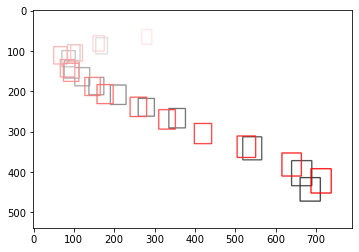

In [16]:
print("Серые прямоугольники - реальные детекты лиц из видео")
print("Красные прямоугольники - предсказанные фильтром по истории наблюдений")
print("Насыщенность цвета отражает течение времени")

# Для наглядности выводим каждый третий кадр:
plt.imshow(
    seminar.render_bboxes(bboxes_xysr[2::3], predictions_xysr[2::3], is_xysr=True)
)
plt.show()

Обратите внимание на отдельно стоящий красный прямоугольник в центре. На этом кадре лицо не нашлось, наблюдения нет. Есть только предсказание, которое неплохо интерполирует между соседними кадрами.

### Другие примеры фильтрации (писать код не нужно)

#### Синусоида

Серые прямоугольники — реальные детекты лиц из видео.
Красные прямоугольники — предсказанные фильтром по истории наблюдений.
Насыщенность цвета отражает течение времени.


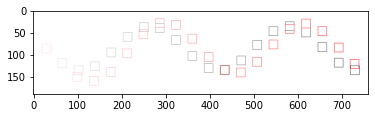

In [17]:
def generate_sin_boxes():
    bboxes = []
    for x in np.linspace(0, 14, 20):
        bboxes.append([50 * x, 50 * np.sin(x), 20, 20])
    return bboxes


bboxes = generate_sin_boxes()
bboxes_xysr = [(ltwh2xysr(bbox) if bbox is not None else None) for bbox in bboxes]
predictions_xysr, _ = predict(bboxes_xysr)

print("Серые прямоугольники — реальные детекты лиц из видео.")
print("Красные прямоугольники — предсказанные фильтром по истории наблюдений.")
print("Насыщенность цвета отражает течение времени.")
plt.imshow(seminar.render_bboxes(bboxes_xysr, predictions_xysr, is_xysr=True))
plt.show()

#### Масштаб

Серые прямоугольники — реальные детекты лиц из видео.
Красные прямоугольники — предсказанные фильтром по истории наблюдений.
Насыщенность цвета отражает течение времени.


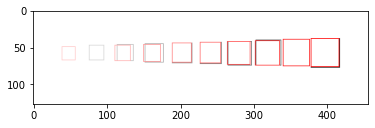

In [18]:
def generate_scale_boxes():
    bboxes = []
    for x in np.linspace(0, 7, 10):
        s = 3 * (x + 6)
        bboxes.append([50 * x - s / 2, -s / 2, s, s])
    return bboxes


bboxes = generate_scale_boxes()
bboxes_xysr = [(ltwh2xysr(bbox) if bbox is not None else None) for bbox in bboxes]
predictions_xysr, _ = predict(bboxes_xysr)

print("Серые прямоугольники — реальные детекты лиц из видео.")
print("Красные прямоугольники — предсказанные фильтром по истории наблюдений.")
print("Насыщенность цвета отражает течение времени.")
plt.imshow(seminar.render_bboxes(bboxes_xysr, predictions_xysr, is_xysr=True))
plt.show()

Фильтр хорошо оценивает линейный рост размера прямоугольника: предсказанные красные прямоугольники почти совпадают с наблюдаемыми серыми.

## Часть 2. Simple online and realtime tracking (SORT)

В предыдущей части семинара мы настроили фильтр Калмана. В этой части реализуем простой алгоритм трекинга на его основе.

### Simple online and realtime tracking (SORT)

Мы хотим сгруппировать прямоугольники с разных кадров для каждого человека.

Выполнять группировку мы будем последовательно: кадр за кадром. Связывать прямоугольники на соседних кадрах будем в два шага:

1. предскажем куда может переместиться прямоугольник за один кадр используя фильтр Калмана;
2. из обнаруженных на следующем кадре прямоугольников найдём ближайший к предсказанному.

На изображении ниже X и Y это координаты пикселя, а T - время. Разными цветами помечены прямоугольники разных лиц.

<img align="left" src="resources/matching.jpg" width="60%" height="60%">
<div style="clear:both;"></div>

Близость двух прямоугольников будем мерить используя Intersection Over Union (IoU):

<img align="left" src="resources/iou.jpg" width="35%" height="35%">
<div style="clear:both;"></div>

Используя IoU мы сможем померить близость между каждой парой предскзанных и наблюдаемых прямоугольников. Тогда мы сможем выбрать наиболее сильные связи решив задачу о максимальном паросочетании в двудольном графе:

<img align="left" src="resources/bipartite.jpg" width="70%" height="70%">
<div style="clear:both;"></div>

ЗАДАНИЕ. Реализуйте функцию, которая вычисляет Intersection Over Union (IoU) между всеми предсказаниями и обнаруженными прямоугольниками.

Поскольку время на задание ограничено, предлагаем использовать наиболее простые подходы. Быстродействие не учитывается.

In [19]:
def bb_intersection_over_union(boxA, boxB):
    # determine the (x, y)-coordinates of the intersection rectangle
    xA = max(boxA[0], boxB[0])
    yA = max(boxA[1], boxB[1])
    xB = min(boxA[0] + boxA[2], boxB[0] + boxB[2])
    yB = min(boxA[1] + boxA[3], boxB[1] + boxB[3])
    # compute the area of intersection rectangle
    interArea = max(0, xB - xA) * max(0, yB - yA)
    # compute the area of both the prediction and ground-truth
    # rectangles
    boxAArea = boxA[2] * boxA[3]
    boxBArea = boxB[2] * boxB[3]
    # compute the intersection over union by taking the intersection
    # area and dividing it by the sum of prediction + ground-truth
    # areas - the interesection area
    iou = interArea / float(boxAArea + boxBArea - interArea)
    # return the intersection over union value
    return iou

In [20]:
def batch_iou(predictions, detections):
    """Вычислить Intersection over Union между каждым предсказанием и детектом.

    Все прямоугольники в формате [left, top, width, height].

    Вход:
    1. predictions: Предсказания фильтра Калмана, матрица размера (N, 4).
    2. detections: Обнаруженные детектором прямоугольники, матрица размера (K, 4).

    Выход: Матрица размера (N, K) с попарными IoU.
    """
    result = np.zeros(shape=(len(predictions), len(detections)))
    for i, prediction in enumerate(predictions):
        for j, detection in enumerate(detections):
            result[i, j] = bb_intersection_over_union(prediction, detection)
    return result


assert check.check_batch_iou(batch_iou)

Результат: отлично!


Теперь приступим к поиску соответствий между предсказаниями и детектами.

В оригинальной реализации SORT используется Венгерский алгоритм. Предлагается реализовать более простой вариант: жадный алгоритм. Жадный алгоритм на каждом шаге добавляет соответствие с максимальным IoU, затем удаляет связанные прямоугольники из рассмотрения.

ЗАДАНИЕ. Реализовать жадный алгоритм поиска соответствий. Жадность алгоритма не проверяется. Любой разумный алгоритм должен пройти тесты.

Полезные функции:
```python

np.argmax(A, axis=None):
    """Возвращает индексы максимальных элементов в направлении оси axis."""
    
np.take_along_axis(A, indices, axis=None):
    """Позволяет выбрать элементы матрицы по результату np.argmax."""
```

In [21]:
def match_bboxes(iou):
    """Найти соответствия между предсказаниями и детектами.

    ВНИМАНИЕ: Связывать прямоугольники с нулевым IoU не нужно.

    В обозначениях ниже N - число предсказаний, K - число детектов.

    Вход: Матрица попарных значений IoU с размером (N, K).

    Выход: Список длины N, в котором для каждого предсказания указан номер соответствующего детекта.
           Если какое-то предсказание оказалось несвязанным, в списке нужно указать None.
    """
    iou = iou.copy()
    ninf = -1
    matches = [None] * len(iou)
    if iou.size == 0:
        return matches
    while True:
        candidates = np.argmax(iou, axis=1)
        values = np.take_along_axis(iou, candidates[:, None], 1)[:, 0]
        best_candidate = np.argmax(values)
        best_value = values[best_candidate]
        if best_value <= 0:
            break
        matches[best_candidate] = candidates[best_candidate]
        iou[best_candidate] = ninf
        iou[:, candidates[best_candidate]] = ninf
    return matches


assert check.check_match_bboxes(match_bboxes)

Результат: отлично!


Функция ниже релизует простой вариант алгоритма SORT.

1. Для каждого прямоугольника на первом кадре создается новый трек.

2. Для последующих кадров выполняется поиск соответствий с использоанием IoU.

3. Если какой-то трек не имеет соответствий более 2-х кадров, он заканчивается.

4. Если какой-то прямоугольник не попал в трек, для него создается новый трек.

In [22]:
from collections import defaultdict

from seminar import xysr2ltwh, ltwh2xysr, create_kalman_filter


def track_sort(detections):
    """Сгруппировать прямоугольники с разных кадров используя фильтр Калмана и IoU.

    Вход: Список ответов детектора для каждого кадра. Каждый ответ детектора это список
          прямоугольников в формате LTWH.

    Выход: Список меток прямоугольников для каждого кадра. Метки для каждого кадра это список
           целочисленных меток всех прямоугольников кадра.
    """
    num_tracks = 0
    track_frames = defaultdict(list)
    track_detection_ids = defaultdict(list)
    track_filters = {}
    for frame, frame_detections in enumerate(detections):
        print("Кадр", frame)

        # Закончить старые треки:
        for track in list(track_filters):
            last_track_frame = track_frames[track][-1]
            if last_track_frame < frame - 2:
                del track_filters[track]
                print("Трек {} завершён".format(track))

        # Предсказать следующие прямоугольники для треков:
        for filter in track_filters.values():
            filter.predict()
        active_tracks = list(track_filters)
        predictions = [xysr2ltwh(track_filters[i].x[:4]) for i in active_tracks]

        # Связать предсказания и детекты:
        iou = batch_iou(predictions, frame_detections)
        matches = match_bboxes(iou)
        print(
            "Продолжено треков: {}".format(len([m for m in matches if m is not None]))
        )

        # Обновить треки:
        for track_id, match in enumerate(matches):
            if match is None:
                continue
            track = active_tracks[track_id]
            track_frames[track].append(frame)
            track_detection_ids[track].append(match)
            track_filters[track].update(ltwh2xysr(frame_detections[match]))

        # Добавить новые треки:
        all_detections = set(range(len(frame_detections)))
        matched_detections = {m for m in matches if m is not None}
        unmatched_detections = all_detections - matched_detections
        for i in unmatched_detections:
            track_frames[num_tracks].append(frame)
            track_detection_ids[num_tracks].append(i)

            bbox = frame_detections[i]
            initial_state = list(ltwh2xysr(bbox)) + [0, 0, 0]
            track_filters[num_tracks] = create_kalman_filter(initial_state)

            print("Трек {} создан".format(num_tracks))
            num_tracks += 1

    # Сформировать ответ:
    labels = [[None] * len(frame_detections) for frame_detections in detections]
    for track in track_frames.keys():
        for frame, detection_id in zip(track_frames[track], track_detection_ids[track]):
            labels[frame][detection_id] = track

    # Проверим, что заполнили все метки:
    for frame_labels in labels:
        for label in frame_labels:
            assert label is not None

    return labels


labels = track_sort(detections)

Кадр 0
Продолжено треков: 0
Трек 0 создан
Кадр 1
Продолжено треков: 0
Трек 1 создан
Трек 2 создан
Кадр 2
Продолжено треков: 1
Трек 3 создан
Кадр 3
Трек 0 завершён
Продолжено треков: 2
Кадр 4
Трек 1 завершён
Продолжено треков: 1
Кадр 5
Продолжено треков: 1
Трек 4 создан
Кадр 6
Трек 3 завершён
Продолжено треков: 1
Кадр 7
Продолжено треков: 1
Трек 5 создан
Кадр 8
Трек 4 завершён
Продолжено треков: 2
Кадр 9
Продолжено треков: 2
Кадр 10
Продолжено треков: 2
Кадр 11
Продолжено треков: 2
Трек 6 создан
Кадр 12
Продолжено треков: 3
Кадр 13
Продолжено треков: 3
Кадр 14
Продолжено треков: 3
Кадр 15
Продолжено треков: 3
Кадр 16
Продолжено треков: 3
Трек 7 создан
Кадр 17
Продолжено треков: 2
Кадр 18
Продолжено треков: 2
Кадр 19
Трек 6 завершён
Трек 7 завершён
Продолжено треков: 2
Кадр 20
Продолжено треков: 2
Кадр 21
Продолжено треков: 2
Кадр 22
Продолжено треков: 2
Кадр 23
Продолжено треков: 2
Кадр 24
Продолжено треков: 2
Кадр 25
Продолжено треков: 2
Трек 8 создан
Кадр 26
Продолжено треков: 2
Кадр 

In [23]:
error = seminar.eval_mismatch_rate(labels, markup)
print("Доля несоответствий с разметкой: {:.2f}".format(error))

Доля несоответствий с разметкой: 0.17


### Визуализация

In [24]:
seminar.render_video_bboxes(VIDEO_PATH, OUTPUT_PATH, detections, labels)

 99%|█████████▉| 118/119 [00:01<00:00, 96.75it/s] 


На видео прямоугольники разных треков помечены разным цветом.

Мигание цвета на каких-то лицах - это ошибки трекинга. Более точная настройка параметров (STD ошибок в фильтре Калмана) может решить проблему. Часть проблем нельзя решить методом SORT на видео с низким FPS.

In [25]:
print(OUTPUT_PATH)
Video(OUTPUT_PATH)

data/output-demo.mp4


Если видео не отображается, откройте его самостоятельно через плеер.

ВОПРОС. В каких случаях трекинг работает хорошо, а в каких плохо?

## Часть 3. Deep SORT

В предыдущей части семинара мы реализовали простой трекер алгоритмом SORT. В этой части дополним его моделью распознавания лиц.

In [26]:
# Видео, куда сохранится результат трекинга:
OUTPUT_PATH = "data/output-demo-deep.mp4"

### Модель сравнения лиц

<img align="left" src="resources/embedding.jpg" width="80%" height="80%">
<div style="clear:both;"></div>

Мы применили модель извлечения признаков к обнаруженным лицам. Для кажого лица мы построили признаковое описание из 128 чисел. Результаты работы модели загружены в список embeddings. Для каждого кадра в нем хранится список эмбеддингов для обнаруженных лиц.

In [27]:
print("Лица на кадре 1:", detections[1])
print("Эмбеддинги лиц на кадре 1: массив с размером", np.asarray(embeddings[1]).shape)

Лица на кадре 1: [[163, 397, 54, 70], [378, 93, 33, 46]]
Эмбеддинги лиц на кадре 1: массив с размером (2, 128)


Сравним лица с разных кадров. В качестве меры удаленности двух эмбеддингов будем использовать косинусное расстояние:

<img align="left" src="resources/cos.jpg" width="50%" height="50%">
<div style="clear:both;"></div>

ЗАДАНИЕ. Реализуйте вычисление косинусного расстояния между двумя наборами эмбеддингов (все со всеми).

Полезные функции:

```python
np.linalg.norm(A, axis=1, keepdims=True)  # Возвращает матрицу (N, 1) с нормами строк матрицы A.

np.sqrt(A)  # Поэлементно извлекает корень.
```

In [28]:
def cosine_distance(emb1, emb2):
    return np.dot(emb1 / np.linalg.norm(emb1), emb2 / np.linalg.norm(emb2))

In [29]:
def batch_cosine_distance(embeddings1, embeddings2):
    """Посчитать косинусное расстояние для двух пар эмбедингов.

    Вход:
        embeddings1: Первый набор эмбеддингов, матрица размера (N, 128).
        embeddings2: Второй набор эмбеддингов, матрица размера (K, 128).

    Выход: Матрица размера (N, K) с косинусными расстояниями между векторами.
    """
    result = np.zeros((len(embeddings1), len(embeddings2)))
    for i, x in enumerate(embeddings1):
        for j, y in enumerate(embeddings2):
            result[i, j] = cosine_distance(x, y)
    return result


assert check.check_batch_cosine_distance(batch_cosine_distance)

Результат: отлично!


Метод DeepSORT имеет несколько отличий от SORT. Мы реализуем только учёт близости эмбеддингов лиц.

Пусть имеется два прямоугольника $B_1 = [l_1, t_1, w_1, h_1]$ и $B_2 = [l_2, t_2, w_2, h_2]$. Эмбеддинг первого лица - $E_1$, второго - $E_2$.

Близость двух лиц будет определяться взвешенной суммой Intersection over Union (IoU) и косинусного расстояния:

$Similarity = \alpha IoU(B_1, B_2) + (1 - \alpha) \cos(E_1, E_2)$

ЗАДАНИЕ. Реализуйте функцию, которая вычисляет близость двух лиц.

Используйте функции:
```python

batch_cosine_distance(embeddings1, embeddings2):
    """(N, 128), (K, 128) -> (N, K)."""

batch_iou(bboxes1, bboxes2):
    """(N, 4), (K, 4) -> (N, K)."""
```

In [30]:
def batch_similarity(bboxes1, embeddings1, bboxes2, embeddings2, alpha=0.5):
    """Возвращает значение близости между парами лиц.

    Вход:
        bboxes1: Первый набор описывающих прямоугольников, матрица размера (N, 4).
        embeddings1: Первый набор эмбеддингов, матрица размера (N, 128).
        bboxes1: Второй набор описывающих прямоугольников, матрица размера (K, 4).
        embeddings2: Второй набор эмбеддингов, матрица размера (K, 128).

    Выход: Матрица близости размера (N, K).
    """
    iou = batch_iou(bboxes1, bboxes2)
    cos_distances = batch_cosine_distance(embeddings1, embeddings2)
    result = alpha * iou + (1 - alpha) * cos_distances
    return result


assert check.check_batch_similarity(batch_similarity)

Результат: отлично!


Функция ниже релизует простой вариант алгоритма Deep SORT.

1. Реализация очень похожа на обычный SORT.
2. Используется обновлённая функция близости.
3. Для каждого трека хранится предыдущий эмбеддинг лица. Он используется для поиска соответствий.

In [31]:
from collections import defaultdict

from seminar import xysr2ltwh, ltwh2xysr, create_kalman_filter, match_bboxes


def track_deep_sort(detections, embeddings, alpha=1, verbose=True):
    """Сгруппировать прямоугольники с разных кадров используя фильтр Калмана и IoU.

    Вход: Список ответов детектора для каждого кадра. Каждый ответ детектора это список
          прямоугольников в формате LTWH.

    Выход: Список меток прямоугольников для каждого кадра. Метки для каждого кадра это список
           целочисленных меток всех прямоугольников кадра.
    """
    num_tracks = 0
    track_frames = defaultdict(list)
    track_detection_ids = defaultdict(list)
    track_embeddings = {}  # Сохранённые эмбеддинги треков.
    track_filters = {}
    for frame, (frame_detections, frame_embeddings) in enumerate(
        zip(detections, embeddings)
    ):
        if verbose:
            print("Кадр", frame)

        # Закончить старые треки:
        for track in list(track_filters):
            last_track_frame = track_frames[track][-1]
            if last_track_frame < frame - 2:
                del track_filters[track]
                if verbose:
                    print("Трек {} завершён".format(track))

        # Предсказать следующие прямоугольники для треков:
        for filter in track_filters.values():
            filter.predict()
        active_tracks = list(track_filters)
        predictions = [xysr2ltwh(track_filters[i].x[:4]) for i in active_tracks]
        embeddings = np.asarray([track_embeddings[i] for i in active_tracks]).reshape(
            (-1, 128)
        )

        # Связать предсказания и детекты используя новую функцию близости:

        iou = batch_similarity(
            predictions, embeddings, frame_detections, frame_embeddings, alpha=alpha
        )
        matches = match_bboxes(iou)
        if verbose:
            print(
                "Продолжено треков: {}".format(
                    len([m for m in matches if m is not None])
                )
            )

        # Обновить треки.
        for track_id, match in enumerate(matches):
            if match is None:
                continue
            track = active_tracks[track_id]
            track_frames[track].append(frame)
            track_detection_ids[track].append(match)
            track_filters[track].update(ltwh2xysr(frame_detections[match]))
            track_embeddings[track] = frame_embeddings[
                match
            ]  # Сохранить эмбеддинг трека.

        # Добавить новые треки:
        all_detections = set(range(len(frame_detections)))
        matched_detections = {m for m in matches if m is not None}
        unmatched_detections = all_detections - matched_detections
        for i in unmatched_detections:
            track_frames[num_tracks].append(frame)
            track_detection_ids[num_tracks].append(i)

            bbox = frame_detections[i]
            initial_state = list(ltwh2xysr(bbox)) + [0, 0, 0]
            track_filters[num_tracks] = create_kalman_filter(initial_state)
            track_embeddings[num_tracks] = frame_embeddings[
                i
            ]  # Сохранить эмбеддинг трека.

            if verbose:
                print("Трек {} создан".format(num_tracks))
            num_tracks += 1

    # Сформировать ответ:
    labels = [[None] * len(frame_detections) for frame_detections in detections]
    for track in track_frames.keys():
        for frame, detection_id in zip(track_frames[track], track_detection_ids[track]):
            labels[frame][detection_id] = track

    # Проверим, что заполнили все метки:
    for frame_labels in labels:
        for label in frame_labels:
            assert label is not None

    return labels


labels = track_deep_sort(detections, embeddings, alpha=0.5, verbose=False)
error = seminar.eval_mismatch_rate(labels, markup)
print("Доля несоответствий с разметкой DeepSORT: {:.2f}".format(error))

Доля несоответствий с разметкой DeepSORT: 0.10


Если выставим $\alpha = 1$, то получим обычный SORT.

In [32]:
labels = track_deep_sort(detections, embeddings, alpha=1, verbose=False)
error = seminar.eval_mismatch_rate(labels, markup)
print("Доля несоответствий с разметкой обычного SORT: {:.2f}".format(error))

Доля несоответствий с разметкой обычного SORT: 0.17


### Визуализация

In [33]:
labels = track_deep_sort(detections, embeddings, alpha=0.5, verbose=False)
seminar.render_video_bboxes(VIDEO_PATH, OUTPUT_PATH, detections, labels)

 99%|█████████▉| 118/119 [00:01<00:00, 98.04it/s]


На видео прямоугольники разных треков помечены разным цветом.

Мигание цвета на каких-то лицах - это ошибки трекинга. Более точная настройка параметров (STD ошибок в фильтре Калмана) может решить проблему. Часть проблем нельзя решить методом SORT на видео с низким FPS.

In [34]:
print(OUTPUT_PATH)
Video(OUTPUT_PATH)

data/output-demo-deep.mp4


ВОПРОС. В каких случаях трекинг работает хорошо, а в каких плохо?

# Ссылки

## Фильтр Калмана

https://habr.com/ru/post/166693/

https://en.wikipedia.org/wiki/Kalman_filter

## Статьи

SORT: https://arxiv.org/abs/1602.00763

DeepSORT: https://arxiv.org/abs/1703.07402

## Реализации

Kalman: https://filterpy.readthedocs.io/en/latest/kalman/KalmanFilter.html

SORT: https://github.com/abewley/sort

DeepSORT: https://github.com/nwojke/deep_sort